# Setup



## Colab setup
---------- Start of generic setup code to get kaggle credentials login and data to work with. Copied much from Workshop 2 ----------

In [72]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
!pip install -U -q scikeras
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

In [73]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

https://drive.google.com/file/d/1DeYgEzZ8Bs8Y3QsHd5YsV-3D-SzVAm4x

In [74]:
# GET data from file I've uploaded to my drive. Use your own kaggle.json and google auth logins etc
downloaded = drive.CreateFile({"id": "1DeYgEzZ8Bs8Y3QsHd5YsV-3D-SzVAm4x"})
downloaded.GetContentFile("predict-energy-consumption.zip")

In [75]:
!unzip predict-energy-consumption.zip

!ls
!mkdir data
!mv *.csv data/

Archive:  predict-energy-consumption.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
darts_logs  predict-energy-consumption.zip  sample_submission.csv  train.csv
data	    sample_data			    test.csv
mkdir: cannot create directory ‘data’: File exists


In [76]:
from google.colab import files

files.upload()
# upload your kaggle.json file

{}

Processing data from the source.

In [77]:
import json

!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

mkdir: cannot create directory ‘/root/.kaggle/’: File exists
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.8/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.8/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [78]:
# GENERIC SUBMIT FUNCTION (uncomment when you want to submit)

# submission = pd.DataFrame(
#    {'key': test.key, 'fare_amount': val_predictions},
#    columns = ['key', 'fare_amount'])
# submission.to_csv('submission.csv', index = False)


#!kaggle competitions submit -c predict-electricity-consumption -f submission.csv -m "[TEAM NAME] Submission"

## Libraries setup

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

sns.set()

# Data exploration

### Modification functions

In [80]:
def replaceNanWithZero(test, train, labels):
    train_labels = labels.replace(np.nan, 0.0)

    for col in train.columns:
        train[col] = train[col].replace(np.nan, 0.0)

    for col in test.columns:
        test[col] = test[col].replace(np.nan, 0.0)

    return test, train, train_labels

In [81]:
# PCA to get a lesser number of features, then going to feed into basic nn see what we can do
from sklearn.decomposition import PCA


def PCA_Performance(train, test):
    variance = [0.5, 0.6, 0.75, 0.8, 0.85, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99]

    for var in variance:
        pca = PCA(n_components=var)
        pca.fit(train)
        transformed_Train = pca.transform(train)
        # transformed_Test = pca.transform(test)
        print(
            f"Retained {var} of variance with {len(transformed_Train.T)} number of features"
        )

In [82]:
def month_to_season(month: int) -> str:
    assert 1 <= month < 13
    if 3 <= month < 6:
        return "spring"
    elif 6 <= month < 9:
        return "summer"
    elif 9 <= month < 12:
        return "autumn"
    else:
        return "winter"

In [83]:
def cast_types(df: pd.DataFrame) -> pd.DataFrame:

    # Cast time, respect timezone
    df["time"] = pd.to_datetime(df["time"], utc=True).dt.tz_convert("Europe/Tallinn")

    # Cast remaining columns
    df = df.astype(
        {
            "temp": "float32",
            "dwpt": "float32",
            "rhum": "int32",
            "prcp": "float32",
            # TODO: Snow might be integer too, check it
            "snow": "float32",
            "wdir": "int32",
            "wspd": "float32",
            "wpgt": "float32",
            "pres": "float32",
            "coco": "category",
            "el_price": "float32",
        }
    )

    # Change coco categories from float to int representation
    new_categories = [int(category) for category in df["coco"].cat.categories]

    df["coco"] = df["coco"].cat.rename_categories(new_categories)

    return df

In [84]:
def explode_datetime(
    df: pd.DataFrame, datetime_column: str, without_prefix: bool = False
) -> pd.DataFrame:

    prefix = "" if without_prefix else f"{datetime_column}_"

    if f"{prefix}year" in df.columns:
        print(f"Column {prefix}year already exists")
        return df

    date_info = pd.DataFrame(
        data=[
            [x.year, x.month, x.day, x.hour, x.weekday()] for x in df[datetime_column]
        ],
        columns=[
            f"{prefix}year",
            f"{prefix}month",
            f"{prefix}day",
            f"{prefix}hour",
            f"{prefix}weekday",
        ],
    ).astype(np.int32)

    df = pd.concat([df.reset_index(), date_info], axis=1).set_index("index")

    return df

## Exploration

In [85]:
# Here we can split into train/test for verification while we train whatever works)
train = pd.read_csv("data/train.csv")
train_labels = train["consumption"]  # y vals in this case are concumption
# GIVEN time is a string we just gonna drop that mfer, cbf processing it etc

test = pd.read_csv("data/test.csv")

# Have to predict consumption for these values. Consumption unkown.
# At this point should have a train and test without Nan values:)

In [86]:
train.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,consumption
0,2021-09-01 00:00:00+03:00,11.20,10.30,94.00,NaN,NaN,320.00,7.20,16.70,1012.60,2.00,0.09,0.58
1,2021-09-01 01:00:00+03:00,10.70,9.60,93.00,NaN,NaN,320.00,7.20,13.00,1012.60,2.00,0.09,0.59
2,2021-09-01 02:00:00+03:00,9.90,9.00,94.00,NaN,NaN,320.00,7.20,13.00,1012.20,2.00,0.09,0.69
3,2021-09-01 03:00:00+03:00,10.00,8.40,90.00,NaN,NaN,330.00,7.20,13.00,1011.90,1.00,0.09,1.02
4,2021-09-01 04:00:00+03:00,9.00,8.10,94.00,NaN,NaN,300.00,3.60,13.00,1011.40,2.00,0.09,0.68


## Preprocessing

### First look

In [87]:
train.describe()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,consumption
count,8592.00,8592.00,8592.00,2159.00,119.00,8592.00,8592.00,8592.00,8592.00,8396.00,8592.00,8590.00
mean,6.74,2.49,77.01,0.06,78.32,201.56,9.16,20.87,1013.23,4.90,0.16,1.05
std,9.26,8.18,17.52,0.38,63.13,87.79,4.83,9.96,12.59,4.96,0.12,1.10
min,-26.10,-28.70,20.00,0.00,0.00,0.00,0.00,2.90,962.60,1.00,0.00,0.00
25%,0.40,-2.90,66.00,0.00,20.00,150.00,7.20,13.00,1006.50,2.00,0.09,0.36
50%,6.20,1.90,83.00,0.00,60.00,210.00,7.20,18.50,1014.70,3.00,0.14,0.81
75%,13.22,9.00,91.00,0.00,130.00,270.00,10.80,27.80,1020.70,5.00,0.20,1.37
max,31.40,20.90,100.00,7.90,220.00,360.00,31.70,63.00,1047.50,25.00,4.00,10.38


In [88]:
train.isna().sum()

time              0
temp              0
dwpt              0
rhum              0
prcp           6433
snow           8473
wdir              0
wspd              0
wpgt              0
pres              0
coco            196
el_price          0
consumption       2
dtype: int64

Most missing values are for snow and precipitation

For snow it is quite a lot of data

- Delete it?
- Impute it with zero when temprature is over 0?
    - How many is left?
    
For coco it is a problem, I think this will be useful information for model

- Are the NaNs sparsely distributed?
    - If so, we can impute from the most common value in +- 2 or 3 values before and after (timeseries)f
- Can the information be found elsewhere?
    - Where is the model house located?

To the precipitation

- That is a huge problem
    - I think this data might be valuable
    - To many values missing for intelligent imputation
- Either find external source, remove it all, or impute with pure zeros
- Even if we delete it a lot of the information is stored in humidity
    - Or is it?

In [89]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8592 entries, 0 to 8591
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         8592 non-null   object 
 1   temp         8592 non-null   float64
 2   dwpt         8592 non-null   float64
 3   rhum         8592 non-null   float64
 4   prcp         2159 non-null   float64
 5   snow         119 non-null    float64
 6   wdir         8592 non-null   float64
 7   wspd         8592 non-null   float64
 8   wpgt         8592 non-null   float64
 9   pres         8592 non-null   float64
 10  coco         8396 non-null   float64
 11  el_price     8592 non-null   float64
 12  consumption  8590 non-null   float64
dtypes: float64(12), object(1)
memory usage: 872.8+ KB


In [90]:
train.loc[:, ["rhum", "wdir", "coco"]].mod(1, fill_value=0).abs().sum()

rhum   0.00
wdir   0.00
coco   0.00
dtype: float64

In [91]:
# Recasting to the best suited type
train = cast_types(train)
test = cast_types(test)

train.dtypes

time           datetime64[ns, Europe/Tallinn]
temp                                  float32
dwpt                                  float32
rhum                                    int32
prcp                                  float32
snow                                  float32
wdir                                    int32
wspd                                  float32
wpgt                                  float32
pres                                  float32
coco                                 category
el_price                              float32
consumption                           float64
dtype: object

### Exploding time

In [92]:
# Explode datetime object into separate components
# Minutes and seconds not extracted
## Contain only zeros
## Found through correlation matrix

train = explode_datetime(train, "time", True)
test = explode_datetime(test, "time", True)


# Add season category

train["season"] = train["month"].apply(lambda x: month_to_season(x)).astype("category")
test["season"] = test["month"].apply(lambda x: month_to_season(x)).astype("category")

train.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,consumption,year,month,day,hour,weekday,season
index,,,,,,,,,,,,,,,,,,,
0,2021-09-01 00:00:00+03:00,11.20,10.30,94,NaN,NaN,320,7.20,16.70,1012.60,2,0.09,0.58,2021,9,1,0,2,autumn
1,2021-09-01 01:00:00+03:00,10.70,9.60,93,NaN,NaN,320,7.20,13.00,1012.60,2,0.09,0.59,2021,9,1,1,2,autumn
2,2021-09-01 02:00:00+03:00,9.90,9.00,94,NaN,NaN,320,7.20,13.00,1012.20,2,0.09,0.69,2021,9,1,2,2,autumn
3,2021-09-01 03:00:00+03:00,10.00,8.40,90,NaN,NaN,330,7.20,13.00,1011.90,1,0.09,1.02,2021,9,1,3,2,autumn
4,2021-09-01 04:00:00+03:00,9.00,8.10,94,NaN,NaN,300,3.60,13.00,1011.40,2,0.09,0.68,2021,9,1,4,2,autumn


### Coco imputation

In [93]:
train[~train["coco"].isin([14, 15, 16, 21, 22]) & ~train["snow"].isna()][
    "coco"
].value_counts()

4     50
1     11
2     10
3      9
7      5
5      2
6      1
8      1
17     0
23     0
22     0
21     0
20     0
19     0
18     0
13     0
16     0
15     0
14     0
12     0
10     0
9      0
25     0
Name: coco, dtype: int64

It's not very sparse. Could be worked on, I do not wanna waste time now

Will create new category for NaN with label 0 and impute it

In [94]:
if not 0 in test["coco"].cat.categories:
    test["coco"] = test["coco"].cat.add_categories([0])
test["coco"] = test["coco"].fillna(0)

if not 0 in train["coco"].cat.categories:
    train["coco"] = train["coco"].cat.add_categories([0])
train["coco"] = train["coco"].fillna(0)

### Snow imputation

In [95]:
to_plot = train[~train["snow"].isna()]
to_plot

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,consumption,year,month,day,hour,weekday,season
index,,,,,,,,,,,,,,,,,,,
1641,2021-11-08 08:00:00+02:00,0.50,0.40,99,NaN,10.00,330,14.40,33.30,997.30,15,0.11,0.82,2021,11,8,8,0,autumn
1977,2021-11-22 08:00:00+02:00,-4.30,-7.60,78,NaN,0.00,290,7.20,16.70,1014.60,1,0.28,1.29,2021,11,22,8,0,autumn
2001,2021-11-23 08:00:00+02:00,-2.20,-3.60,90,NaN,0.00,170,10.80,24.10,1010.20,14,0.19,0.62,2021,11,23,8,1,autumn
2097,2021-11-27 08:00:00+02:00,-0.40,-1.20,94,NaN,60.00,60,10.80,20.40,1000.70,4,0.13,1.90,2021,11,27,8,5,autumn
2121,2021-11-28 08:00:00+02:00,-3.00,-3.80,94,NaN,70.00,20,7.20,14.80,999.70,14,0.16,0.64,2021,11,28,8,6,autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5049,2022-03-30 09:00:00+03:00,-6.80,-8.70,86,NaN,40.00,210,7.20,14.80,1005.70,1,0.24,1.39,2022,3,30,9,2,spring
5073,2022-03-31 09:00:00+03:00,-3.50,-6.90,77,NaN,20.00,200,3.60,11.10,1010.10,1,0.32,1.40,2022,3,31,9,3,spring
5169,2022-04-04 09:00:00+03:00,0.10,-2.60,82,NaN,10.00,200,14.40,24.10,1000.50,4,0.10,1.38,2022,4,4,9,0,spring


In [96]:
to_plot["snow"].describe()

count   119.00
mean     78.32
std      63.13
min       0.00
25%      20.00
50%      60.00
75%     130.00
max     220.00
Name: snow, dtype: float64

In [97]:
to_plot["snow"].median()

60.0

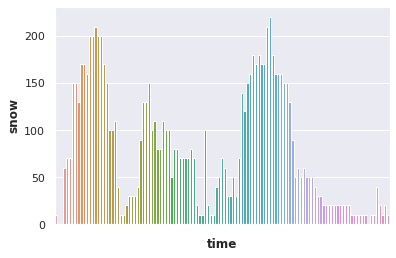

In [99]:
g1 = sns.barplot( x="time", y="snow", data=to_plot)
g1.set(xticklabels=[])
print()

<AxesSubplot: xlabel='day', ylabel='month'>

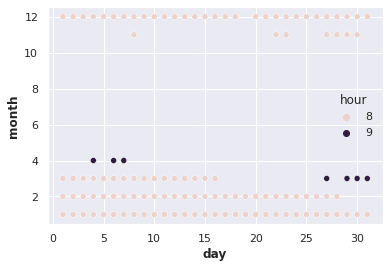

In [101]:
sns.scatterplot(data=to_plot, x="day", y="month", hue="hour")

<AxesSubplot: xlabel='day', ylabel='hour'>

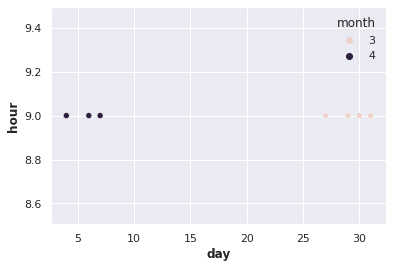

In [102]:
sns.scatterplot(data=to_plot[to_plot["hour"] != 8], x="day", y="hour", hue="month")

In [103]:
to_plot[to_plot["hour"] != 8]

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,consumption,year,month,day,hour,weekday,season
index,,,,,,,,,,,,,,,,,,,
4977,2022-03-27 09:00:00+03:00,-3.50,-11.90,52,NaN,10.00,330,21.60,37.00,1024.00,2,0.10,1.45,2022,3,27,9,6,spring
5025,2022-03-29 09:00:00+03:00,-3.80,-6.10,84,NaN,10.00,330,7.20,16.70,1001.00,14,0.28,1.42,2022,3,29,9,1,spring
5049,2022-03-30 09:00:00+03:00,-6.80,-8.70,86,NaN,40.00,210,7.20,14.80,1005.70,1,0.24,1.39,2022,3,30,9,2,spring
5073,2022-03-31 09:00:00+03:00,-3.50,-6.90,77,NaN,20.00,200,3.60,11.10,1010.10,1,0.32,1.40,2022,3,31,9,3,spring
5169,2022-04-04 09:00:00+03:00,0.10,-2.60,82,NaN,10.00,200,14.40,24.10,1000.50,4,0.10,1.38,2022,4,4,9,0,spring
5217,2022-04-06 09:00:00+03:00,-1.60,-5.30,76,NaN,20.00,260,14.40,29.60,990.50,3,0.18,1.15,2022,4,6,9,2,spring
5241,2022-04-07 09:00:00+03:00,3.30,3.00,98,NaN,10.00,190,7.20,18.50,987.10,7,0.15,0.75,2022,4,7,9,3,spring


In [104]:
to_plot[~to_plot["snow"].isna() & to_plot.index.isin(np.arange(4954, 5241))]

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,consumption,year,month,day,hour,weekday,season
index,,,,,,,,,,,,,,,,,,,
4977,2022-03-27 09:00:00+03:00,-3.50,-11.90,52,NaN,10.00,330,21.60,37.00,1024.00,2,0.10,1.45,2022,3,27,9,6,spring
5025,2022-03-29 09:00:00+03:00,-3.80,-6.10,84,NaN,10.00,330,7.20,16.70,1001.00,14,0.28,1.42,2022,3,29,9,1,spring
5049,2022-03-30 09:00:00+03:00,-6.80,-8.70,86,NaN,40.00,210,7.20,14.80,1005.70,1,0.24,1.39,2022,3,30,9,2,spring
5073,2022-03-31 09:00:00+03:00,-3.50,-6.90,77,NaN,20.00,200,3.60,11.10,1010.10,1,0.32,1.40,2022,3,31,9,3,spring
5169,2022-04-04 09:00:00+03:00,0.10,-2.60,82,NaN,10.00,200,14.40,24.10,1000.50,4,0.10,1.38,2022,4,4,9,0,spring
5217,2022-04-06 09:00:00+03:00,-1.60,-5.30,76,NaN,20.00,260,14.40,29.60,990.50,3,0.18,1.15,2022,4,6,9,2,spring


From what I see in the data the snow variable is collected only once per day, either at 8 or 9 o'clock. It becomes 9 o'clock after the shift to summer time. 

The variable will probably be useless for our prediction, since we need only august. Still I think it might be useful to have it. If the performence of training is lacking, this is the first candidate for cleaning.

For better differentiation I will copy the measured data throughout the whole day.

**IMPORTANT**

For the following code to work I am making an assumption the data is perfect. Specifically, that there is no time input missing in the whole dataset. 

I have not check the assumption yet. It is necessary to do so.

In [105]:
# Prepare the data for further preprocessing
# Copy the snow values collected at 9th hour
## to the 8th hour of the same day

hour_cond = test["hour"] == 9
snow_cond = ~(test["snow"].isna())
combined_view = test[hour_cond & snow_cond]

test.loc[combined_view.index - 1, "snow"] = combined_view["snow"].values

In [106]:
# Every value of snow in test is NaN
# Fill with zeros
print((test["snow"].isna() | test["snow"] == 0).all())
test["snow"] = test["snow"].fillna(0)

False


In [107]:
# Prepare the data for further preprocessing
# Copy the snow values collected at 9th hour
## to the 8th hour of the same day

hour_cond = train["hour"] == 9
snow_cond = ~(train["snow"].isna())
combined_view = train[hour_cond & snow_cond]

train.loc[combined_view.index - 1, "snow"] = combined_view["snow"].values

In [109]:
hour_cond = train["hour"] == 8
snow_cond = ~(train["snow"].isna())
combined_view = train[hour_cond & snow_cond]

# Get indexes that need to be changed
list_of_lists_indexes_to_change = np.array([
    np.arange(x - 8, x + 16) for x in combined_view.index
])
idxs_to_change = np.concatenate(list_of_lists_indexes_to_change).ravel()

# Get values that should be imputed at the place of indexe
values_to_impute = combined_view.loc[combined_view.index.repeat(24), "snow"].values

# Put it all together
train.loc[idxs_to_change, "snow"] = values_to_impute

In [110]:
train.loc[idxs_to_change, :].sample(n=10, random_state=111)

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,consumption,year,month,day,hour,weekday,season
index,,,,,,,,,,,,,,,,,,,
3113,2022-01-08 16:00:00+02:00,-2.30,-4.30,86,NaN,70.00,160,14.40,20.40,1008.50,14,0.17,1.98,2022,1,8,16,5,winter
2968,2022-01-02 15:00:00+02:00,-4.80,-6.90,85,NaN,110.00,140,14.40,25.90,1008.70,14,0.07,1.19,2022,1,2,15,6,winter
5040,2022-03-30 00:00:00+03:00,-7.60,-8.40,94,NaN,40.00,240,3.60,7.40,1004.90,2,0.19,1.46,2022,3,30,0,2,spring
3990,2022-02-14 05:00:00+02:00,1.20,-3.10,73,NaN,150.00,220,14.40,31.50,1007.30,4,0.01,3.91,2022,2,14,5,0,winter
2812,2021-12-27 03:00:00+02:00,-7.40,-8.80,90,NaN,130.00,260,7.20,11.10,1009.30,14,0.09,1.82,2021,12,27,3,0,winter
2111,2021-11-27 22:00:00+02:00,-3.30,-5.00,88,NaN,60.00,40,10.80,29.60,999.00,14,0.20,0.58,2021,11,27,22,5,autumn
2233,2021-12-03 00:00:00+02:00,-4.70,-6.20,89,NaN,170.00,60,10.80,20.40,989.60,14,0.13,1.87,2021,12,3,0,4,winter
2474,2021-12-13 01:00:00+02:00,1.00,0.90,99,NaN,100.00,280,7.20,11.10,1021.10,5,0.13,1.55,2021,12,13,1,0,winter
4015,2022-02-15 06:00:00+02:00,1.80,-2.50,73,NaN,150.00,200,14.40,31.50,1007.70,4,0.10,0.49,2022,2,15,6,1,winter


It seems my magic works!

Now let's impute the rest of NaNs with zeros.

In [111]:
train["snow"] = train["snow"].fillna(0)
test["snow"] = test["snow"].fillna(0)

train["snow"].isna().any()

False

### Correlation heatmap

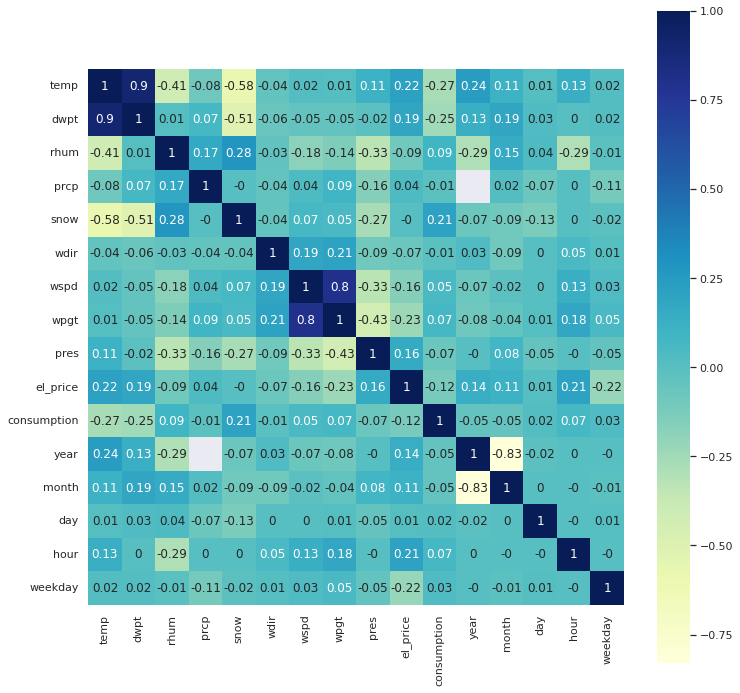

In [112]:
plt.figure(figsize=(12, 12))

cov_matrix = train.corr()
sns.heatmap(cov_matrix.round(2), annot=True, cmap="YlGnBu", square=True)
plt.show()

<AxesSubplot: >

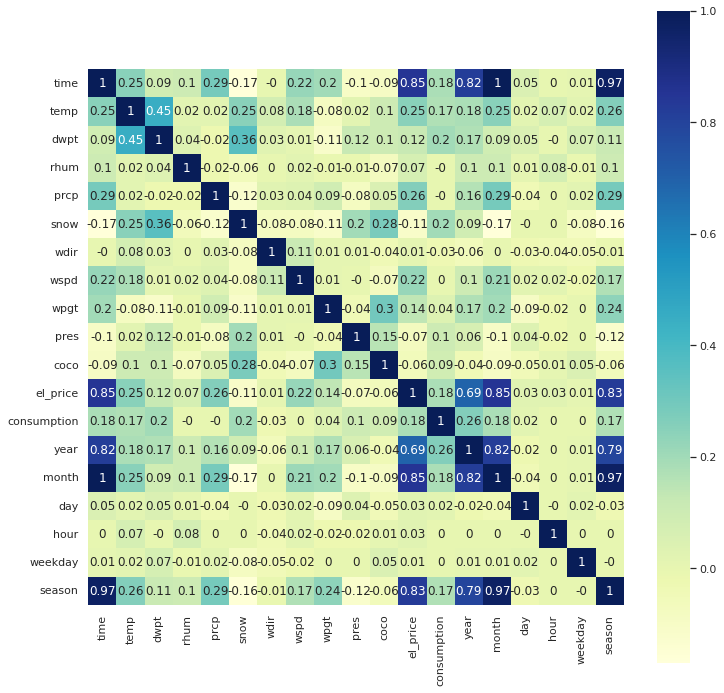

In [113]:
# Correlation method I found at https://stackoverflow.com/questions/48035381/correlation-among-multiple-categorical-variables-pandas
# Might give completely wrong information, I do not understand its asumptions
# From what I understand it transforms categorical to nominal values and computes correlation

plt.figure(figsize=(12, 12))

train_corr = train.apply(lambda x: pd.factorize(x)[0]).corr().round(2)

sns.heatmap(train_corr, annot=True, cmap="YlGnBu", square=True)

# Models

## Transformer

Inspired by [Heiko Onnen](https://towardsdatascience.com/transformer-unleashed-deep-forecasting-of-multivariate-time-series-in-python-9ca729dac019)

### Setup

In [115]:
import os

!pip install darts

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae, mape, rmse
from darts.models import TransformerModel
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.losses import MAELoss, SmapeLoss
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from sklearn.preprocessing import LabelEncoder

from torch.cuda import is_available as is_cuda_available
from torch.nn import MSELoss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [116]:
# Temporary, repalce NaN with zeros
train.isna().any(axis=0)

time           False
temp           False
dwpt           False
rhum           False
prcp            True
snow           False
wdir           False
wspd           False
wpgt           False
pres           False
coco           False
el_price       False
consumption     True
year           False
month          False
day            False
hour           False
weekday        False
season         False
dtype: bool

In [118]:
#train = train.fillna(0)
train.isna().values.any()

True

In [133]:
#test = test.fillna(0)
test.isna().values.any()

False

## Data preparation for training

In [134]:
ts_label = TimeSeries.from_times_and_values(
    times=pd.DatetimeIndex(train["time"]), values=train["consumption"]
)

# check attributes of the time series
print("components:", ts_label.components)
print("duration:", ts_label.duration)
print("frequency:", ts_label.freq)
print("frequency:", ts_label.freq_str)
print(
    "has date time index? (or else, it must have an integer index):",
    ts_label.has_datetime_index,
)
print("deterministic:", ts_label.is_deterministic)
print("univariate:", ts_label.is_univariate)

components: Index(['0'], dtype='object', name='component')
duration: 357 days 23:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [135]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8592 entries, 0 to 8591
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype                         
---  ------       --------------  -----                         
 0   time         8592 non-null   datetime64[ns, Europe/Tallinn]
 1   temp         8592 non-null   float32                       
 2   dwpt         8592 non-null   float32                       
 3   rhum         8592 non-null   int32                         
 4   prcp         2159 non-null   float32                       
 5   snow         8592 non-null   float32                       
 6   wdir         8592 non-null   int32                         
 7   wspd         8592 non-null   float32                       
 8   wpgt         8592 non-null   float32                       
 9   pres         8592 non-null   float32                       
 10  coco         8592 non-null   category                      
 11  el_price     8592 non-null   float32       

In [136]:
le_season = LabelEncoder()

le_season.fit(train["season"])

df_transformer = train.copy(deep=True)
df_transformer["season"] = le_season.transform(df_transformer["season"])

In [137]:
df_transformer = df_transformer.drop(
    ["weekday", "month", "day", "hour", "year"], axis=1
)

ts_covF = TimeSeries.from_dataframe(
    df_transformer.loc[:, df_transformer.columns != "consumption"].set_index("time")
)

# check attributes of the time series
print("components:", ts_covF.components)
print("duration:", ts_covF.duration)
print("frequency:", ts_covF.freq)
print("frequency:", ts_covF.freq_str)
print(
    "has date time index? (or else, it must have an integer index):",
    ts_covF.has_datetime_index,
)
print("deterministic:", ts_covF.is_deterministic)
print("univariate:", ts_covF.is_univariate)

components: Index(['temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres',
       'coco', 'el_price', 'season'],
      dtype='object', name='component')
duration: 357 days 23:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: False


In [138]:
SPLIT = pd.Timestamp(
    year=2022, month=8, day=3, hour=23, tzinfo=train.loc[0, "time"].tzinfo
)
SPLIT

Timestamp('2022-08-03 23:00:00+0300', tz='Europe/Tallinn')

In [139]:
ts_train_label, ts_val_label = ts_label.split_after(SPLIT)
print("training start:", ts_train_label.start_time())
print("training end:", ts_train_label.end_time())
print("training duration:", ts_train_label.duration)
print("val start:", ts_val_label.start_time())
print("val end:", ts_val_label.end_time())
print("val duration:", ts_val_label.duration)


scaler_label = Scaler()
scaler_label.fit_transform(ts_train_label)
ts_ttrain = scaler_label.transform(ts_train_label)
ts_tval = scaler_label.transform(ts_val_label)
ts_tall = scaler_label.transform(ts_label)

training start: 2021-09-01 00:00:00+03:00
training end: 2022-08-03 23:00:00+03:00
training duration: 336 days 23:00:00
val start: 2022-08-04 00:00:00+03:00
val end: 2022-08-24 23:00:00+03:00
val duration: 20 days 23:00:00


In [140]:
covF_train, covF_val = ts_covF.split_after(SPLIT)

print("training start:", covF_train.start_time())
print("training end:", covF_train.end_time())
print("training duration:", covF_train.duration)
print("val start:", covF_val.start_time())
print("val end:", covF_val.end_time())
print("val duration:", covF_val.duration)

scalerF = Scaler()
scalerF.fit(covF_train)
covF_ttrain = scalerF.transform(covF_train)
covF_tval = scalerF.transform(covF_val)
covF_t = scalerF.transform(ts_covF)

pd.options.display.float_format = "{:.2f}".format
print("first and last row of scaled feature covariates:")
covF_t.pd_dataframe().iloc[[0, -1]]

training start: 2021-09-01 00:00:00+03:00
training end: 2022-08-03 23:00:00+03:00
training duration: 336 days 23:00:00
val start: 2022-08-04 00:00:00+03:00
val end: 2022-08-24 23:00:00+03:00
val duration: 20 days 23:00:00
first and last row of scaled feature covariates:


component,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,season
time,,,,,,,,,,,,
2021-09-01 00:00:00+03:00,0.65,0.79,0.93,NaN,0.00,0.89,0.23,0.23,0.59,0.08,0.09,0.00
2022-08-24 23:00:00+03:00,0.84,0.94,0.73,0.00,0.00,0.86,0.47,0.11,0.69,0.08,0.43,0.67


In [141]:
covT = datetime_attribute_timeseries(
    ts_label.time_index, attribute="hour", one_hot=False
)
covT = covT.stack(
    datetime_attribute_timeseries(covT.time_index, attribute="weekday", one_hot=False)

)
covT = covT.stack(
    datetime_attribute_timeseries(covT.time_index, attribute="month", one_hot=False)
)
covT = covT.stack(
    datetime_attribute_timeseries(covT.time_index, attribute="day", one_hot=False)
)
covT = covT.stack(
    datetime_attribute_timeseries(covT.time_index, attribute="year", one_hot=False)
)
covT = covT.stack(
    datetime_attribute_timeseries(covT.time_index, attribute="quarter", one_hot=False)
)

covT = covT.add_holidays(country_code="EE")
covT = covT.astype(np.float32)

covT_train, covT_val = covT.split_after(SPLIT)

scalerT = Scaler()
scalerT.fit(covT_train)
covT_ttrain = scalerT.transform(covT_train)
covT_tval = scalerT.transform(covT_val)
covT_t = scalerT.transform(covT)

covT_t = covT_t.astype(np.float32)

pd.options.display.float_format = "{:.0f}".format
print("first and last row of unscaled time covariates:")
covT.pd_dataframe().iloc[[0, -1]]

first and last row of unscaled time covariates:


component,hour,weekday,month,day,year,quarter,holidays
time,,,,,,,
2021-09-01 00:00:00+03:00,0,2,9,1,2021,3,0
2022-08-24 23:00:00+03:00,23,2,8,24,2022,3,0


In [142]:
# combine feature and time covariates along component dimension: axis=1
ts_cov = ts_covF.concatenate(covT.slice_intersect(ts_covF), axis=1)  # unscaled F+T
cov_t = covF_t.concatenate(covT_t.slice_intersect(covF_t), axis=1)  # scaled F+T
cov_ttrain = covF_ttrain.concatenate(
    covT_ttrain.slice_intersect(covF_ttrain), axis=1
)  # scaled F+T training set
cov_tval = covF_tval.concatenate(
    covT_tval.slice_intersect(covF_tval), axis=1
)  # scaled F+T test set


pd.options.display.float_format = "{:.2f}".format
print("first two and last two rows of unscaled covariates:")
ts_cov.pd_dataframe().iloc[[0, 1, -2, -1]]

first two and last two rows of unscaled covariates:


component,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,season,hour,weekday,month,day,year,quarter,holidays
time,,,,,,,,,,,,,,,,,,,
2021-09-01 00:00:00+03:00,11.20,10.30,94.00,NaN,0.00,320.00,7.20,16.70,1012.60,2.00,0.09,0.00,0.00,2.00,9.00,1.00,2021.00,3.00,0.00
2021-09-01 01:00:00+03:00,10.70,9.60,93.00,NaN,0.00,320.00,7.20,13.00,1012.60,2.00,0.09,0.00,1.00,2.00,9.00,1.00,2021.00,3.00,0.00
2022-08-24 22:00:00+03:00,22.10,17.00,73.00,0.00,0.00,160.00,6.00,9.30,1021.00,2.00,0.55,2.00,22.00,2.00,8.00,24.00,2022.00,3.00,0.00
2022-08-24 23:00:00+03:00,22.10,18.10,78.00,0.00,0.00,310.00,15.00,9.30,1021.00,2.00,0.43,2.00,23.00,2.00,8.00,24.00,2022.00,3.00,0.00


## Non-optimized model training

### Model specification

In [143]:
LOAD = (
    True  # True = load previously saved model from disk?  False = (re)train the model
)
BASEFOLDER = "/model/transformer"
ATTEMPT_NUM = 7

SAVE = f"{BASEFOLDER}/attempt{ATTEMPT_NUM:02d}.tar"  # file name to save the model under

MODEL_NAME = f"transformer_consumption_attempt{ATTEMPT_NUM:02d}"

mpath = os.path.abspath(os.getcwd()) + SAVE  # path and file name to save the model

USE_GPU = True

EPOCHS = 100

ACTF = "GEGLU"  # activation function, relu (default) or gelu
BATCH = 16  # batch size
DECODE = 5  # decoder layers
DIM_FF = 512  # dimensions of the feedforward network, default 2048
DROPOUT = 0.12996442284806184  # dropout rate
ENCODE = 7  # encoder layers
FEAT = 32  # d_model = number of expected features in the inputs, up to 512
HEADS = 16  # default 8
INLEN = 166  # input size
LEARN = 0.0006152134629387717  # learning rate
NORM_TYPE = None  # Normalisation after FF network
N_FC = 6  # output size
SCHLEARN = None  # a PyTorch learning rate scheduler; None = constant rate
VALWAIT = 1  # epochs to wait before evaluating the loss on the test/validation set

RAND = 42  # random seed
N_SAMPLES = 100  # number of times a prediction is sampled from a probabilistic model
N_JOBS = -1  # parallel processors to use;  -1 = all processors


# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]

# for deterministic prediction set to None
LIKELIHOOD = QuantileRegression(quantiles=QUANTILES)

# and set loss function
LOSS_FN = MAELoss()

In [144]:
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=6,
    min_delta=0.0001,
    mode="min",
)

# Is cuda available in torch?
if is_cuda_available() and USE_GPU:
    pl_trainer_kwargs = {
        "accelerator": "gpu",
        "devices": [0],
        "callbacks": [my_stopper],
    }
else:
    if USE_GPU:
        print("Cuda not available\nSwitching to cpu...")
    pl_trainer_kwargs = {"accelerator": "cpu", "callbacks": [my_stopper]}

model = TransformerModel(
    input_chunk_length=INLEN,
    output_chunk_length=N_FC,
    batch_size=BATCH,
    n_epochs=EPOCHS,
    model_name=MODEL_NAME,
    nr_epochs_val_period=VALWAIT,
    d_model=FEAT,
    nhead=HEADS,
    num_encoder_layers=ENCODE,
    num_decoder_layers=DECODE,
    dim_feedforward=DIM_FF,
    dropout=DROPOUT,
    activation=ACTF,
    random_state=RAND,
    likelihood=LIKELIHOOD,
    optimizer_kwargs={"lr": LEARN},
    add_encoders={
        "cyclic": {"past": ["hour", "weekday"]},
    },
    save_checkpoints=True,
    force_reset=True,
    norm_type=NORM_TYPE,
    loss_fn=LOSS_FN,
    pl_trainer_kwargs=pl_trainer_kwargs,
)

Cuda not available
Switching to cpu...


### Model training

In [145]:
# Necessary for HPC instance of University of Tartu
# Old dependency uses SLURMS deprecated parameter
# This code sets it as it should be
os.environ["SLURM_NTASKS_PER_NODE"] = "2"

In [146]:
# %%capture output
## Output captured, if you wanna see run output.show() in the next cell
## Keeps output even if jupyter IDE is closed with server executing instructions
## Captured using %%capture output (https://stackoverflow.com/questions/32539832/keep-jupyter-notebook-running-after-closing-browser-tab)
if LOAD:
    print("have loaded a previously saved model from disk:" + mpath)
    model = TransformerModel.load(mpath)  # load previously model from disk
else:
    model.fit(
        ts_ttrain,
        past_covariates=cov_ttrain,
        val_past_covariates=cov_t,
        val_series=ts_tval,
        verbose=True,
        num_loader_workers=2,
    )
    print("have saved the model after training:", mpath)
    model = TransformerModel.load_from_checkpoint(MODEL_NAME)
    model.save(mpath)

have loaded a previously saved model from disk:/content/model/transformer/attempt07.tar


FileNotFoundError: ignored

### Prediction

In [ ]:
# Predicting on models trained with GPU requires GPU for prediction
# I'm not gonna fix it now since it is not needed
# Possible solution can be custom trainer
# Or change in the loaded model's trainer
# https://unit8co.github.io/darts/generated_api/darts.models.forecasting.pl_forecasting_module.html?highlight=torchforecastingmodel
# Or get yourself GPU
ts_tpred = model.predict(
    n=len(ts_tval),
    series=ts_ttrain,
    # Uncomment when using likelihood parameter
    num_samples=N_SAMPLES,
    n_jobs=N_JOBS,
    verbose=True,
    past_covariates=cov_t,
    trainer=None,
)

In [ ]:
print("start:", ts_tpred.start_time(), "; end:", ts_tpred.end_time())

In [ ]:
# Used with likelihood = QuantileRegression(quantiles=QUANTILES) parameter during model creation
ts_tpredq = ts_tpred.quantile_timeseries(0.5)
ts_predq = scaler_label.inverse_transform(ts_tpredq)

# Predictions for ensamble aggregation
# Uncomment to change them
# ts_predq.pd_dataframe().rename(columns={"0_quantiles": "consumption"}).to_csv(
#     f"predictions/transformer_for_metamodel_a{ATTEMPT_NUM:02d}.csv"
# )

q50_RMSE = rmse(ts_predq, ts_val_label)
q50_MAPE = mape(ts_predq, ts_val_label)
q50_MAE = mae(ts_predq, ts_val_label)
print("RMSE:", f"{q50_RMSE:.2f}")
print("MAPE:", f"{q50_MAPE:.2f}")
print("MAE:", f"{q50_MAE:.2f}")

In [ ]:
# Use when likelihood=None

# ts_pred = scaler_label.inverse_transform(ts_tpred)

# nonprob_RMSE = rmse(ts_pred, ts_val_label)
# nonprob_MAPE = mape(ts_pred, ts_val_label)
# nonprob_MAE = mae(ts_pred, ts_val_label)

# print("RMSE:", f'{nonprob_RMSE:.2f}')
# print("MAPE:", f'{nonprob_MAPE:.2f}')
# print("MAE:", f'{nonprob_MAE:.2f}')

## Model hyperparameters optimization

### Optimization task definition

In [ ]:
BASEFOLDER = "/model/transformer"
ATTEMPT_NUM = 1

SAVE = f"{BASEFOLDER}/attempt_optimisation{ATTEMPT_NUM:02d}.tar"  # file name to save the model under

MODEL_NAME = f"transformer_optimised_attempt{ATTEMPT_NUM:02d}"

USE_GPU = True

RAND = 42  # random seed
N_JOBS = -1  # parallel processors to use;  -1 = all processors

moptpath = os.path.abspath(os.getcwd()) + SAVE  # path and file name to save the model

For better parameter explanation refer to [model specification](#Model-specification)

In [ ]:
cov_t.pd_dataframe().columns

In [ ]:
# https://stackoverflow.com/questions/1482308/how-to-get-all-subsets-of-a-set-powerset
from itertools import chain, combinations


def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s) + 1)))


len(powerset(["hour", "weekday"]))

In [ ]:
# Optuna objective function for Hyperparameter optimisation
# Study is saved in the db, for further information visit https://optuna.readthedocs.io/en/stable/


def objective(trial):
    EPOCHS = 100

    date_time_powerset = powerset(["quarter", "day", "dayofyear", "week", "month"])
    position_powerset = powerset(["relative"])

    # Useless
    # Can be deleted on new study creation
    SETUP = trial.suggest_categorical(
        "SETUP", ["ChangeCov_ttrainAndCov_tvalToCov_tDuringFittingLongerVal"]
    )

    # select input and output chunk lengths
    INLEN = trial.suggest_int("INLEN", 138, 256)
    N_FC = trial.suggest_int("N_FC", 1, 96)

    # Other hyperparameters
    ENCODE = trial.suggest_int("ENCODE", 3, 10)
    DECODE = trial.suggest_int("DECODE", 3, ENCODE)
    DROPOUT = trial.suggest_float("DROPOUT", 0.0, 0.4)
    LEARN = trial.suggest_float("LEARN", 5e-5, 1e-3, log=True)
    DIM_FF = trial.suggest_categorical("DIM_FF", [256, 512, 1024, 2048, 4096])
    BATCH = trial.suggest_categorical("BATCH", [16, 32, 64])
    ACTF = trial.suggest_categorical("ACTF", ["relu", "gelu", "GEGLU"])
    NORM_TYPE = trial.suggest_categorical(
        "NORM_TYPE", ["LayerNorm", "RMSNorm", "LayerNormNoBias", None]
    )
    # Unused, remains kept since optuna does not allow
    # changes of categoricals between multiple trials in the same study
    loss_key = trial.suggest_categorical("LOSS_FN", ["SmapeLoss", "MSELoss", "MAELoss"])

    # This might fail on run
    # If fails run with suggest_categorical
    HEADS = trial.suggest_categorical("HEADS", [2, 4, 8, 16])
    FEAT = 32

    PAST_DATETIME_ATTR_ID = trial.suggest_int(
        "PAST_DATETIME_ATTR_ID", 0, len(date_time_powerset) - 1
    )
    PAST_POSITION_ID = trial.suggest_int(
        "PAST_POSITION_ID", 0, len(position_powerset) - 1
    )

    # Might be interesting to try
    SCHLEARN = None
    VALWAIT = 1  # epochs to wait before evaluating the loss on the test/validation set

    QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]
    # for deterministic prediction set to None
    LIKELIHOOD = QuantileRegression(quantiles=QUANTILES)

    # I decided to use MAELoss, its hardcoded in model specification
    # Useful code for finding more metrics
    # loss_dict = {"SmapeLoss": SmapeLoss, "MSELoss": MSELoss, "MAELoss": MAELoss}
    # LOSS_FN = loss_dict[loss_key]()

    # throughout training we'll monitor the validation loss for both pruning and early stopping
    pruner = PyTorchLightningPruningCallbackCustom(trial, monitor="val_loss")
    early_stopper = EarlyStopping(
        "val_loss", min_delta=0.0001, patience=4, verbose=True
    )
    callbacks = [pruner, early_stopper]

    # Is cuda available in torch?
    if is_cuda_available() and USE_GPU:
        pl_trainer_kwargs = {
            "accelerator": "gpu",
            "devices": [0],
            "callbacks": callbacks,
        }
        num_workers = 2
    else:
        if USE_GPU:
            print("Cuda not available\nSwitching to cpu...")
        pl_trainer_kwargs = {"accelerator": "cpu", "callbacks": callbacks}
        num_workers = 0

    # reproducibility
    torch.manual_seed(42)

    model = TransformerModel(
        input_chunk_length=INLEN,
        output_chunk_length=N_FC,
        batch_size=BATCH,
        n_epochs=EPOCHS,
        model_name=MODEL_NAME,
        nr_epochs_val_period=VALWAIT,
        d_model=FEAT,
        nhead=HEADS,
        num_encoder_layers=ENCODE,
        num_decoder_layers=DECODE,
        dim_feedforward=DIM_FF,
        dropout=DROPOUT,
        activation=ACTF,
        random_state=RAND,
        likelihood=LIKELIHOOD,
        optimizer_kwargs={"lr": LEARN},
        add_encoders={
            "cyclic": {"past": ["hour", "weekday"]},
            "datetime_attribute": {"past": date_time_powerset[PAST_DATETIME_ATTR_ID]},
            "position": {"past": position_powerset[PAST_POSITION_ID]},
        },
        save_checkpoints=True,
        force_reset=True,
        norm_type=NORM_TYPE,
        loss_fn=MAELoss(),
        pl_trainer_kwargs=pl_trainer_kwargs,
    )

    # train the model
    model.fit(
        ts_ttrain,
        past_covariates=cov_t,
        val_past_covariates=cov_t,
        val_series=ts_tval,
        num_loader_workers=num_workers,
    )

    # reload best model over course of training
    model = TransformerModel.load_from_checkpoint(MODEL_NAME)

    # Evaluate how good it is on the validation set, using MAE
    ts_tpred = model.predict(
        n=len(ts_tval),
        series=ts_ttrain,
        n_jobs=N_JOBS,
        verbose=True,
        past_covariates=cov_t,
        num_samples=N_SAMPLES,
    )

    ts_tpredq = ts_tpred.quantile_timeseries(0.5)
    ts_predq = scaler_label.inverse_transform(ts_tpredq)

    mae_val = mae(ts_predq, ts_val_label, n_jobs=-1, verbose=True)

    return mae_val if mae_val != np.nan else float("inf")

In [ ]:
import logging
import sys

# Add stream handler of stdout to show the optuna messages
if len(optuna.logging.get_logger("optuna").handlers) < 2:
    optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

In [ ]:
NUM_ID = 1

study_name = f"transformer_search_longer_validation{NUM_ID:02d}"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format("transformer-study")
print(storage_name)

In [ ]:
# Exec in case if study is ruined, deletes study
# optuna.delete_study(study_name=study_name, storage=storage_name)

In [ ]:
# for convenience, print some optimization trials information
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


# optimize hyperparameters by minimizing the MAE on the validation set
study = optuna.create_study(
    direction="minimize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)
# Uncomment to run optimize function
# More info at optuna's docs
# study.optimize(objective, n_trials=10, callbacks=[print_callback])

In [ ]:
# For the ability to close jupyter and see progress later
# from datetime import datetime

# with open("flag_4.md", "w") as file:
#     file.write(f"I have finished, get to work peon\nTimestamp:{datetime.now()}\nLog follows:\n\n")
#     file.write(output.stdout)

In [ ]:
# P.S. MSELoss means MAELoss
# I discared MSELoss and it is impossible to change categorical suggestions dynamically in optuna
# More info in objective() function
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
df_trials = study.trials_dataframe()
df_trials_sorted = df_trials[~df_trials["state"].isin(["PRUNED", "FAIL"])].sort_values(
    by="value", ascending=True
)
df_trials_sorted.iloc[0:5, :]

## Final training

### Data preparation of test set

In [ ]:
df_transformer = test.copy(deep=True)
df_transformer["season"] = le_season.transform(df_transformer["season"])

df_transformer

In [ ]:
df_transformer = df_transformer.drop(
    ["weekday", "month", "day", "hour", "year"], axis=1
)

ts_covTest = TimeSeries.from_dataframe(df_transformer.loc[:, :].set_index("time"))

In [ ]:
print("test start:", ts_covTest.start_time())
print("test end:", ts_covTest.end_time())
print("test duration:", ts_covTest.duration)

covF_ttest = scalerF.transform(ts_covTest)

pd.options.display.float_format = "{:.2f}".format
print("first and last row of scaled feature covariates:")
covF_ttest.pd_dataframe().iloc[[0, -1]]

In [ ]:
covT = datetime_attribute_timeseries(
    covF_ttest.time_index, attribute="hour", one_hot=False
)
covT = covT.stack(
    datetime_attribute_timeseries(covT.time_index, attribute="weekday", one_hot=False)
)
covT = covT.stack(
    datetime_attribute_timeseries(covT.time_index, attribute="month", one_hot=False)
)
covT = covT.stack(
    datetime_attribute_timeseries(covT.time_index, attribute="day", one_hot=False)
)
covT = covT.stack(
    datetime_attribute_timeseries(covT.time_index, attribute="year", one_hot=False)
)
covT = covT.stack(
    datetime_attribute_timeseries(covT.time_index, attribute="quarter", one_hot=False)
)

covT = covT.add_holidays(country_code="EE")
covT = covT.astype(np.float32)

covT_ttest = scalerT.transform(covT)

covT_ttest = covT_ttest.astype(np.float32)

pd.options.display.float_format = "{:.0f}".format
print("first and last row of unscaled time covariates:")
covT.pd_dataframe().iloc[[0, -1]]

In [ ]:
# combine feature and time covariates along component dimension: axis=1
ts_covtest = ts_covTest.concatenate(
    covT.slice_intersect(ts_covTest), axis=1
)  # unscaled F+T
cov_ttest = covF_ttest.concatenate(
    covT_ttest.slice_intersect(covF_ttest), axis=1
)  # scaled F+T

cov_ttraintest = cov_t.concatenate(cov_ttest, axis=0)

# Checks that everything is all right
print(
    f"Is cov_ttraintest as long as trian and test together?: {len(cov_ttraintest) == len(train) + len(test)}"
)
print(
    f"Is any NaN in cov_ttraintest?: {cov_ttraintest.pd_dataframe().isna().values.any()}"
)

pd.options.display.float_format = "{:.2f}".format
print("first two and last two rows of unscaled covariates:")
ts_cov.pd_dataframe().iloc[[0, 1, -2, -1]]

### Model specification

`LOAD = True` & `ATTEMP_NUM = 1` loads my final model

In [ ]:
LOAD = (
    True  # True = load previously saved model from disk?  False = (re)train the model
)
BASEFOLDER = "/model/transformer"
FINAL_NUM = 1

SAVE = f"{BASEFOLDER}/final{FINAL_NUM:02d}.tar"  # file name to save the model under

USE_GPU = True

EPOCHS = 22

ACTF = "GEGLU"  # activation function, relu (default) or gelu
BATCH = 16  # batch size
DECODE = 5  # decoder layers
DIM_FF = 512  # dimensions of the feedforward network, default 2048
DROPOUT = 0.12996442284806184  # dropout rate
ENCODE = 7  # encoder layers
FEAT = 32  # d_model = number of expected features in the inputs, up to 512
HEADS = 16  # default 8
INLEN = 166  # input size
LEARN = 0.0006152134629387717  # learning rate
NORM_TYPE = None  # Normalisation after FF network
N_FC = 6  # output size
SCHLEARN = None  # a PyTorch learning rate scheduler; None = constant rate
VALWAIT = 1  # epochs to wait before evaluating the loss on the test/validation set

# PAST_DATETIME_ATTR_ID = 0 # No datetime information
# PAST_POSITION_ID = 0 # No position information

RAND = 42  # random seed
N_SAMPLES = 100  # number of times a prediction is sampled from a probabilistic model
N_JOBS = -1  # parallel processors to use;  -1 = all processors

# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]

# for deterministic prediction set to None
LIKELIHOOD = QuantileRegression(quantiles=QUANTILES)

# and set loss function
LOSS_FN = MAELoss()

MODEL_NAME = f"transformer_final{FINAL_NUM:02d}"

mpath = os.path.abspath(os.getcwd()) + SAVE  # path and file name to save the model

In [ ]:
# Is cuda available in torch?
if is_cuda_available() and USE_GPU:
    pl_trainer_kwargs = {
        "accelerator": "gpu",
        "devices": [0],
    }
else:
    if USE_GPU:
        print("Cuda not available\nSwitching to cpu...")
    pl_trainer_kwargs = {
        "accelerator": "cpu",
    }

model = TransformerModel(
    input_chunk_length=INLEN,
    output_chunk_length=N_FC,
    batch_size=BATCH,
    n_epochs=EPOCHS,
    model_name=MODEL_NAME,
    nr_epochs_val_period=VALWAIT,
    d_model=FEAT,
    nhead=HEADS,
    num_encoder_layers=ENCODE,
    num_decoder_layers=DECODE,
    dim_feedforward=DIM_FF,
    dropout=DROPOUT,
    activation=ACTF,
    random_state=RAND,
    likelihood=LIKELIHOOD,
    optimizer_kwargs={"lr": LEARN},
    add_encoders={
        "cyclic": {"past": ["hour", "weekday"]},
    },
    save_checkpoints=True,
    force_reset=True,
    norm_type=NORM_TYPE,
    loss_fn=LOSS_FN,
    pl_trainer_kwargs=pl_trainer_kwargs,
)

In [ ]:
# %%capture output
## Output captured, if you wanna see run output.show() in the next cell
## Keeps output even if jupyter IDE is closed with server executing instructions
## Captured using %%capture output (https://stackoverflow.com/questions/32539832/keep-jupyter-notebook-running-after-closing-browser-tab)
torch.manual_seed(42)
if LOAD:
    print("have loaded a previously saved model from disk:" + mpath)
    model = TransformerModel.load(mpath)  # load previously model from disk
else:
    model.fit(ts_tall, past_covariates=cov_ttraintest, num_loader_workers=2)
    print("have saved the model after training:", mpath)
    model.save(mpath)

### Prediction

In [ ]:
len(cov_ttest)

In [ ]:
print("training start:", ts_tall.start_time())
print("training end:", ts_tall.end_time())

In [ ]:
# Evaluate how good it is on the validation set, using sMAPE
ts_tpred = model.predict(
    n=len(cov_ttest),
    series=ts_tall,
    n_jobs=N_JOBS,
    verbose=True,
    past_covariates=cov_ttraintest,
    num_samples=N_SAMPLES,
)

In [ ]:
ts_tpredq = ts_tpred.quantile_timeseries(0.5)
ts_predq = scaler_label.inverse_transform(ts_tpredq)

# Uncomment to rewrite predictions
# Change it to you own file
# ts_predq.pd_dataframe().rename(columns={"0_quantiles": "consumption"}).to_csv(
#     f"predictions/tmp_test.csv"  # transformer_test_final{FINAL_NUM:02d}.csv"
# )

In [ ]:
# Kept for further reference
# # Used with likelihood = QuantileRegression(quantiles=QUANTILES) parameter during model creation
# ts_tpredq = ts_tpred.quantile_timeseries(0.5)
# ts_predq = scaler_label.inverse_transform(ts_tpredq)
# s = TimeSeries.pd_series(ts_predq)
# #header = "Q" + format(int(q*100), "02d")
# q50_RMSE = rmse(ts_predq, ts_val_label)
# q50_MAPE = mape(ts_predq, ts_val_label)
# q50_MAE = mae(ts_predq, ts_val_label)
# print("RMSE:", f'{q50_RMSE:.2f}')
# print("MAPE:", f'{q50_MAPE:.2f}')
# print("MAE:", f'{q50_MAE:.2f}')

In [ ]:
# # USE the code we wrote above
# train = train.drop(["consumption"], axis=1)

# train_no_time = train.drop(["time", "coco", "season"], axis=1)
# test_no_time = test.drop(["time", "coco"], axis=1)
# test_no_time, train_no_time, labels = replaceNanWithZero(
#     test_no_time, train_no_time, train_labels
# )

# PCA_Performance(train_no_time, test_no_time)

# XGB Model

Using HyperOpt over various time budgets to experiment with best general hyperparam values.

NOTE: The cells below take a long time to execute and do not need to be run. The provided XGB_Class and XBG_Results (typo lol) files are the outputs of these steps (XGB_Class being the resulting classifier itself, and XBG_Results being the csv of hyperparameters and their respective losses over the HyperOpt trials).

In [ ]:
!pip install hyperopt

#setup etc
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
import random

results = {}

In [ ]:
#NOTE: http://learningsys.org/papers/LearningSys_2015_paper_32.pdf
#sklearn GradientBoostRegressor fundamentally the same as XGBoost, just much slower
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(train, trailabels, test_size=0.25, random_state=8080)

xgb = GradientBoostingRegressor()

xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)

score = mean_squared_error(pred,y_test,squared = True)

score
# default xgb pretty epic

In [ ]:
def objective(search_space):
    model = GradientBoostingRegressor(**search_space)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = mean_squared_error(y_test, y_pred, squared=True)
    return {'loss': accuracy, 'status': STATUS_OK}

search_space={'loss':hp.choice('loss',['squared_error','absolute_error','huber','quantile']),
              'learning_rate':hp.uniform('learning_rate',0.0,1.0),
              'n_estimators':hp.choice('n_estimators',list(range(1,500))),
              'subsample':hp.uniform('subsample',0.0,0.99),
              'criterion':hp.choice('criterion',['squared_error','friedman_mse']),
              'min_samples_split':hp.choice('min_samples_split', list(range(2,500))),
              'min_samples_leaf':hp.choice('min_samples_leaf', list(range(1,500))), 
              'min_weight_fraction_leaf':hp.uniform('min_weight_fraction_leaf', 0.0,0.5),
              'max_depth':hp.choice('max_depth', list(range(1,100))),
              'min_impurity_decrease':hp.uniform('min_impurity_decrease', 0.0,10.0)}
              #there are some other params but they seem largely irrelevant}           
              #'shrinking':hp.choice('shrinking',[True,False])}
algorithm=tpe.suggest

results = []

#gimme gimme 
for i in range(0,5):
  trials =Trials()
  best_params = fmin(fn=objective,space=search_space,algo=algorithm,max_evals=2000,trials=trials)
  best_params['best_loss'] = min(trials.losses())
  results.append(best_params)

In [ ]:
#so I don't have to rerun the above code every time ^
from google.colab import files

df = pd.DataFrame(results)
df.to_csv('XBG_results.csv') 
files.download('XBG_results.csv')

NOTE: Run from here.

In [ ]:
#helper function to convert between HyperOpt numerical and hyperparameter 
#categorical values
def convert_to_params(instance):
  crit = int(instance['criterion'])
  if crit == 0:
    instance.loc['criterion'] = 'squared_error'
  elif crit == 1:
    instance.loc['criterion'] = 'friedman_mse'
  
  los = int(instance['loss'])
  if los == 0:
    instance.loc['loss'] = 'squared_error'
  elif los == 1:
    instance.loc['loss'] = 'absolute_error'
  elif los == 2:
    instance.loc['loss'] = 'huber'
  elif los == 3:
    instance.loc['loss'] = 'quantile'
  
  instance['max_depth'] = int(instance['max_depth'])
  instance['min_samples_leaf'] = int(instance['min_samples_leaf'])
  instance['min_samples_split'] = int(instance['min_samples_split'])
  instance['n_estimators'] = int(instance['n_estimators'])
  return instance

In [ ]:
res = pd.read_csv('XBG_Results.csv')

res2 = res.drop('Unnamed: 0',axis=1)
res2.sort_values('best_loss', inplace=True)
res3 = res2.drop('best_loss',axis=1)
best = res3[:5] #five best results

#print(best) #one best result

We have the five best models. Train each over five random train/test splits and 
pick one with lowest general sum. We do this because num_iterations for HyperOpt was very high, so we want to avoid as much overiftting as possible.

In [ ]:
from numpy.lib.npyio import savez_compressed
models = []
scores = {}
for index, row in best.iterrows():
  params = convert_to_params(row)
  model = GradientBoostingRegressor(**params)
  models.append(model)
  scores[model] = []

for i in range(0,5):
    print(i)
    X_train, X_test, y_train, y_test = train_test_split(train, train_labels, test_size=0.2)

    for model in models:
      model.fit(X_train,y_train)
      pred = model.predict(X_test)
      score = mean_squared_error(pred,y_test,squared = True)
      scores[model].append(score)

In [ ]:
import pickle

#ye ye ye 'manual' blah blah blah
bscore = 100000
best = None
for key in scores.keys():
  thisScores = scores[key]
  score = np.sum(thisScores)
  if score < bscore:
    bscore = score
    best = key

print(best)
out = open('XGB_Class','wb')
pickle.dump(best, out)
out.close()

In [ ]:
#uncomment to load model from pickle
#xgb_model = pickle.load(open('XGB_Class', 'rb'))

# **SVM Model**

In [148]:
from sklearn import preprocessing
X = train.drop(["time", "prcp", "season","consumption"], axis=1)
Y = train['consumption'].values
Y = np.where(np.isnan(Y), 0, Y)
lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform(Y)


In [149]:
X.isnull().sum().sort_values(ascending=False)

temp        0
dwpt        0
rhum        0
snow        0
wdir        0
wspd        0
wpgt        0
pres        0
coco        0
el_price    0
year        0
month       0
day         0
hour        0
weekday     0
dtype: int64

In [150]:

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, encoded, test_size=0.25, random_state=8080)


In [ ]:
from sklearn.svm import SVC
m3 = SVC()
Model3 = m3.fit(X_train, Y_train)
p3 = m3.predict(X_test)


In [152]:
from sklearn import metrics
print("Accuracy of svc :", metrics.accuracy_score(Y_test,p3))

Accuracy of svc : 0.004189944134078212


In [153]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_test,p3,squared = True)


810272.0567970205